# Libraries

In [1]:
#!pip install deep_tabular_augmentation
!pip install sdv==1.3.0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
from Data_Augmentation.vpower_src.utils.auxiliary_functions import *
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [3]:
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.lite import SingleTablePreset
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import CopulaGANSynthesizer

In [4]:
torch.cuda.is_available()

True

# Data pre-processing

Données:
- data_all : ensemble de **tous les vols**, toutes les données, tous les features, ...
- data_flight1  : toutes les données/dfeatures uniquement du **vol 1**
- data_flight1_features : données du **vol 1** et limitation des features utilisés

- real_data : données de **training** de **tous les vols**
- real_data_flight1 : données de **training** du **vol 1**
- real_data_flight1_shorted : données de **training** du **vol 1**, réduites (supp: Power_smoothed < 300)

Caractéristiques: tous les vols/vol unique; tous les features/features limités; données filtrées ou non
-> Travailler avec les données de training uniquement ("real_data_***")


In [5]:
data_dir_s =  "../../Data/synthetic_data"
data_dir_r =  "../../Data/split_quad"
data_dir_da = "../../Data/augmented_data"
data_tag="RD"

In [6]:
# Load data partitions and assign them to dictionary data_all
data_all = {}
#for partition in ["train", "dev_in", "dev_out"]:
#    df = load_data_and_set_index(filepath=os.path.join(data_dir_s, f"{partition}.csv"), index_column_name="index")
#    data_all[partition+"_s"] = df
for partition in ["train", "test", "val", "lourd"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_r, f"{partition}.csv"), index_column_name="index")
    data_all[partition+"_r"] = df

if data_tag=="RD":
    data_all["train"]=data_all["train_r"]
    data_all["test"]=data_all["test_r"]
else:
    data_all["train"]=   pd.concat([data_all["train_r"], data_all["train_s"]])
    data_all["test"] = pd.concat([data_all["test_r"], data_all["test_s"]])
    

data_flight1 = {}
data_flight1["train"] = data_all["train"].loc[data_all["train"]["flight"] == 1]
data_flight1["test"] = data_all["test"].loc[data_all["test"]["flight"] == 1]
data_flight1["train"]


,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
112,2019-04-07 10:13:00,1,0.00,1.4,37.0,24.178350,0.389637,-79.782396,40.458047,270.407091,...,-0.000479,0.033248,-0.114812,-9.824341,4,0,25,R5,9.420778,9.420778
113,2019-04-07 10:13:00,1,0.21,1.4,36.0,23.517269,6.154673,-79.782396,40.458047,270.432353,...,0.011397,0.042173,-0.108319,-9.837841,4,0,25,R5,144.741104,144.741104
114,2019-04-07 10:13:00,1,0.31,1.4,42.0,24.109488,1.025779,-79.782396,40.458047,270.433609,...,0.017794,0.005411,-0.188141,-9.812851,4,0,25,R5,24.731003,24.731003
115,2019-04-07 10:13:00,1,0.50,1.4,42.0,24.189619,0.278312,-79.782396,40.458047,270.459037,...,-0.005043,0.034055,-0.114786,-9.808225,4,0,25,R5,6.732263,6.732263
116,2019-04-07 10:13:00,1,0.61,1.3,41.0,24.192123,0.389637,-79.782396,40.458047,270.460150,...,-0.012929,0.008335,-0.094107,-9.812603,4,0,25,R5,9.426145,9.426145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2019-04-07 10:13:00,1,169.10,1.7,92.0,22.500603,5.033473,-79.782354,40.458037,268.150388,...,0.022862,0.264301,0.581728,-9.760308,4,0,25,R5,113.256177,113.256177
1240,2019-04-07 10:13:00,1,169.20,1.7,90.0,22.493092,5.089135,-79.782354,40.458037,268.170896,...,-0.011390,0.207800,0.540354,-9.742634,4,0,25,R5,114.470383,114.470383
1241,2019-04-07 10:13:00,1,169.30,1.7,92.0,22.498098,5.025521,-79.782354,40.458037,268.153808,...,-0.000938,0.246509,0.592650,-9.784649,4,0,25,R5,113.064672,113.064672


In [7]:
input_features = [
    #time_start,
    "flight",
    "time",
    "wind_speed",
    "wind_angle",
    #battery_voltage,
    #battery_current,
    #position_x,
    #position_y,
    "position_z",
    "orientation_x",
    "orientation_y",
    "orientation_z",
    "orientation_w",
    "velocity_x",
    "velocity_y",
    "velocity_z",
    "angular_x",
    "angular_y",
    "angular_z",
    "linear_acceleration_x",
    "linear_acceleration_y",
    "linear_acceleration_z",
    #speed,
    #payload,
    #altitude,
    #route,
    #power,
    "power_smoothed"
]

In [8]:
data_flight1_features = {}
data_flight1_features["train"] = pd.DataFrame(data_flight1["train"][input_features])
data_flight1_features["test"] = pd.DataFrame(data_flight1["test"][input_features])

In [9]:
real_data = data_all["train"]
print("Real_Data Length: ", len(real_data))

real_data_flight1 = data_flight1["train"]
print("Real_Data_flight1 Length: ", len(real_data_flight1))

Real_Data Length:  139006
Real_Data_flight1 Length:  815


In [10]:
# Delete values of Power_Smoothed < 300 (according to the graph obtained with all the data flight values)

real_data_flight1_shorted = real_data_flight1[real_data_flight1['power_smoothed'] > 300]

# Synthetizers - Single Table Data

In [11]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data)
print('Auto detected data:\n')
metadata

Auto detected data:



{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "time_start": {
            "sdtype": "categorical"
        },
        "flight": {
            "sdtype": "numerical"
        },
        "time": {
            "sdtype": "numerical"
        },
        "wind_speed": {
            "sdtype": "numerical"
        },
        "wind_angle": {
            "sdtype": "numerical"
        },
        "battery_voltage": {
            "sdtype": "numerical"
        },
        "battery_current": {
            "sdtype": "numerical"
        },
        "position_x": {
            "sdtype": "numerical"
        },
        "position_y": {
            "sdtype": "numerical"
        },
        "position_z": {
            "sdtype": "numerical"
        },
        "orientation_x": {
            "sdtype": "numerical"
        },
        "orientation_y": {
            "sdtype": "numerical"
        },
        "orientation_z": {
            "sdtype": "numerical"
        },
        "orientation_w": 

In [12]:
# A: GaussianCopulaSynthesizer

# Step 1.A: Create the synthesizer
synthesizer_Gaussian = GaussianCopulaSynthesizer(metadata)

In [13]:
# B: CopulaGANSynthesizer

# Step 1.B: Create the synthesizer
synthesizer_GAN = CopulaGANSynthesizer(metadata, cuda=True, verbose=True)

In [14]:
# Step 2.A: Train the synthesizer
synthesizer_Gaussian.fit(real_data)
synthesizer_Gaussian.save(filepath='../Models/my_GaussianCopulaSynthesizer.pkl')

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'time'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'wind_speed'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_voltage'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_current'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'position_y'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/

In [15]:
# Step 2.B: Train the synthesizer       /!\ 73min fitting /!\
#synthesizer_GAN.fit(real_data)
#synthesizer_GAN.save(filepath='../Models/my_CopulaGANSynthesizer.pkl')
synthesizer_GAN = CopulaGANSynthesizer.load(filepath='../Models/my_CopulaGANSynthesizer.pkl')

In [16]:
# Step 3.A: Generate synthetic data
synthetic_data_Gaussian = synthesizer_Gaussian.sample(num_rows=15000)
print(len(synthetic_data_Gaussian))

15000


In [17]:
# Step 3.B: Generate synthetic data
synthetic_data_GAN = synthesizer_GAN.sample(num_rows=50000)
print(len(synthetic_data_GAN))

50000


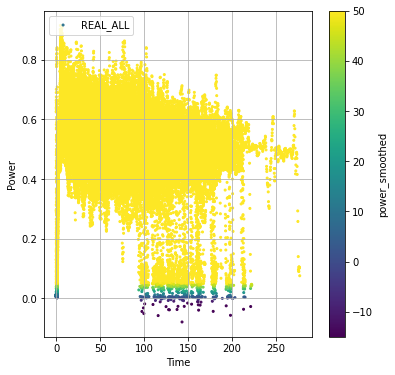

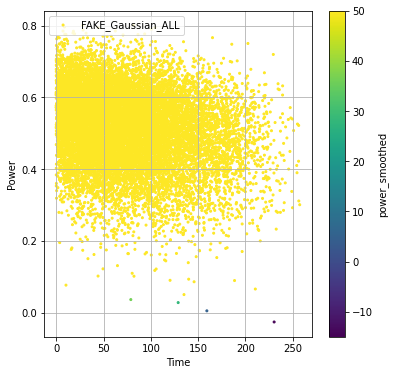

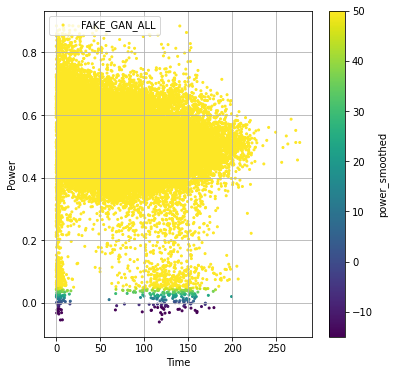

In [18]:
############################################################ Real Data
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(real_data["time"], real_data['power_smoothed'] / 1e3,
            c=real_data[feature_under_study],
            s=4, label="REAL_ALL")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

############################################################ Gaussian
plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_Gaussian["time"],synthetic_data_Gaussian['power_smoothed'] / 1e3,
            c=synthetic_data_Gaussian[feature_under_study],
            s=4, label="FAKE_Gaussian_ALL")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

############################################################ GAN
plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_GAN["time"],synthetic_data_GAN['power_smoothed'] / 1e3,
            c=synthetic_data_GAN[feature_under_study],
            s=4, label="FAKE_GAN_ALL")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

In [19]:
synthetic_data_GAN_sorted = synthetic_data_GAN.sort_values(by=['flight'])

In [20]:
# As GAN model has been train on the whole dataset -> Shape = (15 000, 29)
# synthetic_data_GAN => pandas.core.frame.DataFrame

counts = []
for n, g in synthetic_data_GAN.groupby('flight'):
    count = g['flight'].size
    counts.append(count)

for f ,count in enumerate(counts):
    print(f'Flight {f}: {count} occurrences')
#print(synthetic_data_GAN)

Flight 0: 7528 occurrences
Flight 1: 863 occurrences
Flight 2: 2402 occurrences
Flight 3: 1951 occurrences
Flight 4: 1146 occurrences
Flight 5: 602 occurrences
Flight 6: 329 occurrences
Flight 7: 195 occurrences
Flight 8: 122 occurrences
Flight 9: 105 occurrences
Flight 10: 70 occurrences
Flight 11: 77 occurrences
Flight 12: 143 occurrences
Flight 13: 250 occurrences
Flight 14: 302 occurrences
Flight 15: 285 occurrences
Flight 16: 313 occurrences
Flight 17: 200 occurrences
Flight 18: 146 occurrences
Flight 19: 95 occurrences
Flight 20: 54 occurrences
Flight 21: 23 occurrences
Flight 22: 14 occurrences
Flight 23: 8 occurrences
Flight 24: 1 occurrences
Flight 25: 4 occurrences
Flight 26: 24 occurrences
Flight 27: 19 occurrences
Flight 28: 1 occurrences
Flight 29: 1 occurrences
Flight 30: 1 occurrences
Flight 31: 1 occurrences
Flight 32: 2 occurrences
Flight 33: 1 occurrences
Flight 34: 4 occurrences
Flight 35: 2 occurrences
Flight 36: 1 occurrences
Flight 37: 2 occurrences
Flight 38: 7 o

Filtering data:
(w_l = 50, polyorder = 3) => bonne base pour les hautes TS (bcp samples)
A check pour les TS ~< 300 samples
- 866 samples -> ok avec filtre (w_l= len()/10, polyorder=5)
- 330

In [21]:
count = synthetic_data_GAN_sorted['flight'].value_counts().reset_index()
count.columns = ['Flight Number', 'Count']

print(count[count.Count > 300])
type(count)

   Flight Number  Count
0              2   7528
1              4   2402
2              5   1951
3              6   1146
4              3    863
5              7    602
6              8    329
7             18    313
8             16    302
9            238    301


pandas.core.frame.DataFrame

1951
1951
755
755


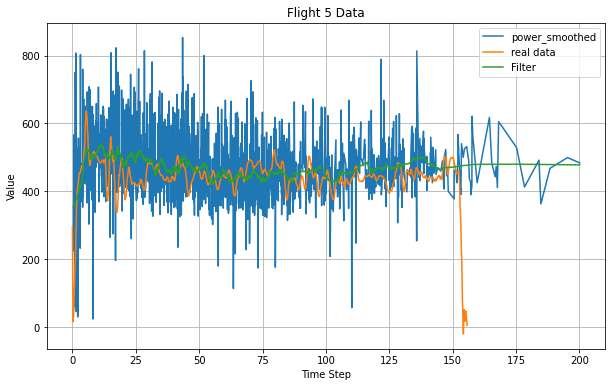

In [30]:
flight_number = 5
topic_to_study = 'power_smoothed'

# Synthetic data processing
flight_data = synthetic_data_GAN_sorted[synthetic_data_GAN_sorted['flight'] == flight_number].sort_values(by=['time'])
data_to_study = flight_data[topic_to_study]
time_steps = flight_data['time']
print(len(data_to_study))
print(len(time_steps))

# Real data processing
real_data_to_study = real_data[real_data['flight'] == flight_number].sort_values(by=['time'])
time_steps_real_data = real_data_to_study['time']
real_data_to_study = real_data_to_study[topic_to_study]
print(len(real_data_to_study))
print(len(time_steps_real_data))

# Filtering data processed
x_filtered = savgol_filter(data_to_study, window_length=round(len(real_data_to_study)/10), polyorder=3)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_steps, data_to_study, label=topic_to_study)
plt.plot(time_steps_real_data, real_data_to_study, label = 'real data')
plt.plot(time_steps, x_filtered, label='Filter')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title(f'Flight {flight_number} Data')
plt.legend()
plt.grid(True)
plt.show()

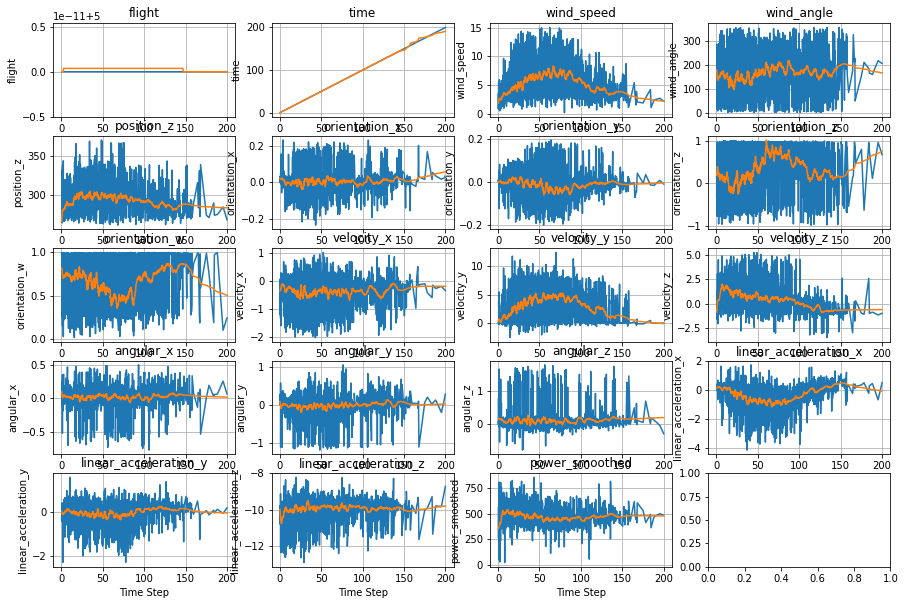

In [31]:
cols_to_display = ["flight", "time", "wind_speed", "wind_angle", "position_z", "orientation_x",
                   "orientation_y", "orientation_z", "orientation_w","velocity_x", "velocity_y",
                   "velocity_z", "angular_x", "angular_y", "angular_z", "linear_acceleration_x",
                   "linear_acceleration_y","linear_acceleration_z","power_smoothed"]

# flight_data
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15,10))

for j, col in enumerate(cols_to_display):
    # Filtering data processed
    x_filt = savgol_filter(flight_data[col], window_length=round(len(real_data_to_study)/10), polyorder=3)
    plt.subplot(5,4,j+1)
    plt.plot(flight_data['time'], flight_data[col])
    plt.plot(flight_data['time'], x_filt)
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.title(col)
    plt.grid(True)
plt.show()

## Data Augmentation - only 1 flight

In [13]:
metadata_flight1 = SingleTableMetadata()
metadata_flight1.detect_from_dataframe(data=real_data_flight1)
print("Auto detected data:\n", metadata_flight1)

Auto detected data:
 {
    "columns": {
        "time_start": {
            "sdtype": "categorical"
        },
        "flight": {
            "sdtype": "numerical"
        },
        "time": {
            "sdtype": "numerical"
        },
        "wind_speed": {
            "sdtype": "numerical"
        },
        "wind_angle": {
            "sdtype": "numerical"
        },
        "battery_voltage": {
            "sdtype": "numerical"
        },
        "battery_current": {
            "sdtype": "numerical"
        },
        "position_x": {
            "sdtype": "numerical"
        },
        "position_y": {
            "sdtype": "numerical"
        },
        "position_z": {
            "sdtype": "numerical"
        },
        "orientation_x": {
            "sdtype": "numerical"
        },
        "orientation_y": {
            "sdtype": "numerical"
        },
        "orientation_z": {
            "sdtype": "numerical"
        },
        "orientation_w": {
            "sdtype": "nu

In [14]:
#GaussianCopulaSynthesizer
# Step 1: Create the synthesizer
synthesizer_Gaussian_flight1 = GaussianCopulaSynthesizer(metadata_flight1)

# Step 2: Train the synthesizer
synthesizer_Gaussian_flight1.fit(real_data_flight1)
synthesizer_Gaussian_flight1.save(filepath='../Models/my_GaussianCopulaSynthesizer_flight1.pkl')

# Step 3: Generate synthetic data - Gaussian
synthetic_data_Gaussian_flight1 = synthesizer_Gaussian_flight1.sample(num_rows=815)
print(len(synthetic_data_Gaussian_flight1))

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'time'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'wind_speed'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_voltage'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_current'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'position_y'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/

815


In [15]:
#CopulaGANSynthesizer
# Step 1: Create the synthesizer
synthesizer_GAN_flight1 = CopulaGANSynthesizer(metadata_flight1, verbose=True, cuda=True)

# Step 2: Train the synthesizer
synthesizer_GAN_flight1.fit(real_data_flight1)
synthesizer_GAN_flight1.save(filepath='../Models/my_CopulaGANSynthesizer_flight1.pkl')

# Step 3: Generate synthetic data - GAN
synthetic_data_GAN_flight1 = synthesizer_GAN_flight1.sample(num_rows=len(real_data_flight1))
print(len(synthetic_data_GAN_flight1))

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'time'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'wind_speed'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_voltage'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_current'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'position_y'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/

Epoch 1, Loss G: -0.0439,Loss D: -0.0042
Epoch 2, Loss G: -0.0708,Loss D: -0.0409
Epoch 3, Loss G: -0.0227,Loss D: -0.1029
Epoch 4, Loss G:  0.0354,Loss D: -0.1253
Epoch 5, Loss G:  0.0050,Loss D: -0.1836
Epoch 6, Loss G:  0.0255,Loss D: -0.2442
Epoch 7, Loss G:  0.0154,Loss D: -0.2773
Epoch 8, Loss G: -0.0040,Loss D: -0.3062
Epoch 9, Loss G: -0.0010,Loss D: -0.3138
Epoch 10, Loss G: -0.0123,Loss D: -0.3572
Epoch 11, Loss G: -0.0983,Loss D: -0.3984
Epoch 12, Loss G: -0.0871,Loss D: -0.5457
Epoch 13, Loss G: -0.2228,Loss D: -0.6347
Epoch 14, Loss G: -0.2068,Loss D: -0.5470
Epoch 15, Loss G: -0.2871,Loss D: -0.6259
Epoch 16, Loss G: -0.2792,Loss D: -0.8194
Epoch 17, Loss G: -0.2290,Loss D: -0.8124
Epoch 18, Loss G: -0.1772,Loss D: -0.9988
Epoch 19, Loss G: -0.1377,Loss D: -0.8417
Epoch 20, Loss G: -0.3384,Loss D: -0.9661
Epoch 21, Loss G: -0.3069,Loss D: -0.8043
Epoch 22, Loss G: -0.2251,Loss D: -1.0438
Epoch 23, Loss G: -0.3735,Loss D: -0.7900
Epoch 24, Loss G: -0.3665,Loss D: -0.7616
E

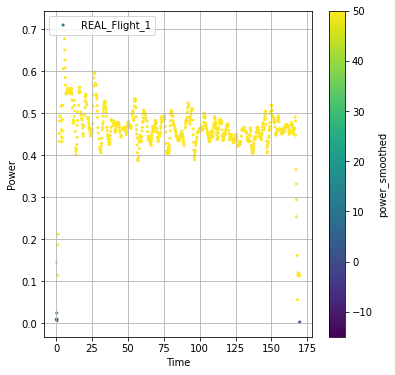

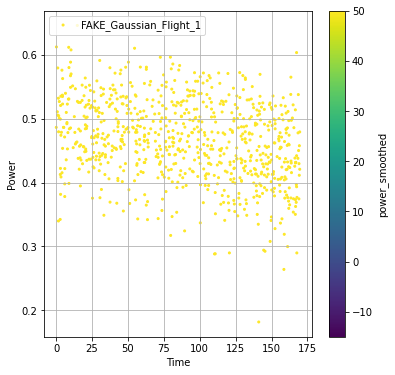

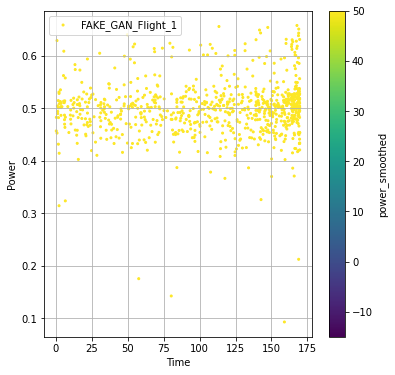

In [16]:
# Step 4: Display Real data
#print(len(real_data_flight1))
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(real_data_flight1["time"],real_data_flight1['power_smoothed'] / 1e3,
            c=real_data_flight1[feature_under_study],
            s=4, label="REAL_Flight_1")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

############################################
# Step 4: Display Synthetic data - Gaussian

plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_Gaussian_flight1["time"],synthetic_data_Gaussian_flight1['power_smoothed'] / 1e3,
            c=synthetic_data_Gaussian_flight1[feature_under_study],
            s=4, label="FAKE_Gaussian_Flight_1")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

############################################
# Step 4: Display Synthetic data - GAN

plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_GAN_flight1["time"],synthetic_data_GAN_flight1['power_smoothed'] / 1e3,
            c=synthetic_data_GAN_flight1[feature_under_study],
            s=4, label="FAKE_GAN_Flight_1")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

### Trying Deleting : 'power_smoothed' < 300

In [17]:
metadata_flight1_shorted = SingleTableMetadata()
metadata_flight1_shorted.detect_from_dataframe(data=real_data_flight1_shorted)
print("Auto detected data:\n", metadata_flight1_shorted)

Auto detected data:
 {
    "columns": {
        "time_start": {
            "sdtype": "categorical"
        },
        "flight": {
            "sdtype": "numerical"
        },
        "time": {
            "sdtype": "numerical"
        },
        "wind_speed": {
            "sdtype": "numerical"
        },
        "wind_angle": {
            "sdtype": "numerical"
        },
        "battery_voltage": {
            "sdtype": "numerical"
        },
        "battery_current": {
            "sdtype": "numerical"
        },
        "position_x": {
            "sdtype": "numerical"
        },
        "position_y": {
            "sdtype": "numerical"
        },
        "position_z": {
            "sdtype": "numerical"
        },
        "orientation_x": {
            "sdtype": "numerical"
        },
        "orientation_y": {
            "sdtype": "numerical"
        },
        "orientation_z": {
            "sdtype": "numerical"
        },
        "orientation_w": {
            "sdtype": "nu

In [18]:
#GaussianCopulaSynthesizer
# Step 1: Create the synthesizer
synthesizer_Gaussian_flight1_shorted = GaussianCopulaSynthesizer(metadata_flight1_shorted)

# Step 2: Train the synthesizer
synthesizer_Gaussian_flight1_shorted.fit(real_data_flight1_shorted)
synthesizer_Gaussian_flight1_shorted.save(filepath='../Models/my_GaussianCopulaSynthesizer_flight1_shorted.pkl')

# Step 3: Generate synthetic data - Gaussian
synthetic_data_Gaussian_flight1_shorted = synthesizer_Gaussian_flight1_shorted.sample(num_rows=2*len(real_data_flight1_shorted))
print(len(synthetic_data_Gaussian_flight1_shorted))

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'time'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'wind_speed'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_voltage'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_current'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'position_y'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/

1592


In [29]:
#CopulaGANSynthesizer
# Step 1: Create the synthesizer
synthesizer_GAN_flight1_shorted = CopulaGANSynthesizer(metadata_flight1_shorted, epochs=1000, verbose=True, cuda=True)

# Step 2: Train the synthesizer
synthesizer_GAN_flight1_shorted.fit(real_data_flight1_shorted)
synthesizer_GAN_flight1_shorted.save(filepath='../Models/my_CopulaGANSynthesizer_flight1_shorted.pkl')

# Step 3: Generate synthetic data - GAN
synthetic_data_GAN_flight1_shorted = synthesizer_GAN_flight1_shorted.sample(num_rows=2*len(real_data_flight1_shorted))
print(len(synthetic_data_GAN_flight1_shorted))

/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'time'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'wind_speed'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_voltage'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'battery_current'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'position_y'. Data will not be rounded.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/

Epoch 1, Loss G: -0.0049,Loss D: -0.0111
Epoch 2, Loss G:  0.0080,Loss D: -0.0193
Epoch 3, Loss G:  0.0214,Loss D: -0.0453
Epoch 4, Loss G:  0.0359,Loss D: -0.0933
Epoch 5, Loss G:  0.0528,Loss D: -0.1578
Epoch 6, Loss G:  0.0199,Loss D: -0.1620
Epoch 7, Loss G:  0.0205,Loss D: -0.1775
Epoch 8, Loss G:  0.0064,Loss D: -0.2319
Epoch 9, Loss G: -0.0878,Loss D: -0.2463
Epoch 10, Loss G: -0.0784,Loss D: -0.3548
Epoch 11, Loss G: -0.1305,Loss D: -0.3304
Epoch 12, Loss G: -0.2192,Loss D: -0.3242
Epoch 13, Loss G: -0.2990,Loss D: -0.4114
Epoch 14, Loss G: -0.4284,Loss D: -0.4267
Epoch 15, Loss G: -0.4672,Loss D: -0.3983
Epoch 16, Loss G: -0.5930,Loss D: -0.3369
Epoch 17, Loss G: -0.7513,Loss D: -0.5096
Epoch 18, Loss G: -0.7257,Loss D: -0.5335
Epoch 19, Loss G: -0.8563,Loss D: -0.5134
Epoch 20, Loss G: -0.8312,Loss D: -0.5884
Epoch 21, Loss G: -0.7495,Loss D: -0.8338
Epoch 22, Loss G: -0.9671,Loss D: -0.6837
Epoch 23, Loss G: -1.0478,Loss D: -0.7178
Epoch 24, Loss G: -1.0233,Loss D: -0.7386
E

In [27]:
synthesizer_GAN_flight1_shorted.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': True,
 'locales': None,
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'discriminator_dim': (256, 256),
 'generator_lr': 0.0002,
 'generator_decay': 1e-06,
 'discriminator_lr': 0.0002,
 'discriminator_decay': 1e-06,
 'batch_size': 500,
 'discriminator_steps': 1,
 'log_frequency': True,
 'verbose': True,
 'epochs': 1000,
 'pac': 10,
 'cuda': True,
 'numerical_distributions': {},
 'default_distribution': 'beta'}

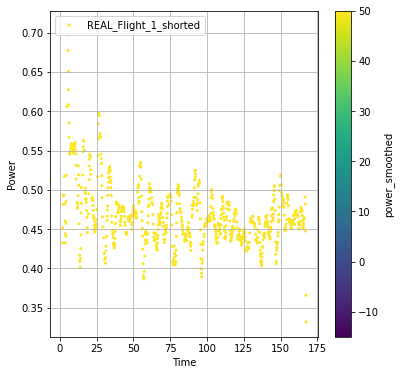

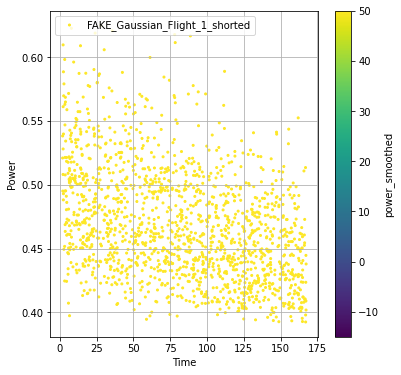

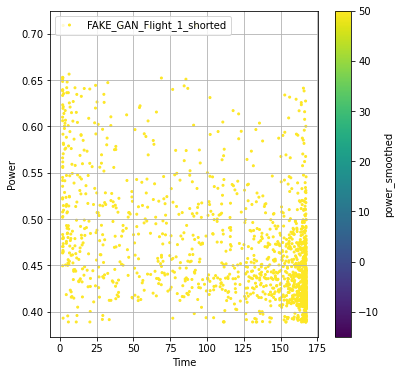

In [30]:
# Step 4: Display Real data
#print(len(real_data_flight1))
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(real_data_flight1_shorted["time"],real_data_flight1_shorted['power_smoothed'] / 1e3,
            c=real_data_flight1_shorted[feature_under_study],
            s=4, label="REAL_Flight_1_shorted")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

############################################
# Step 4: Display Synthetic data - Gaussian

plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_Gaussian_flight1_shorted["time"],synthetic_data_Gaussian_flight1_shorted['power_smoothed'] / 1e3,
            c=synthetic_data_Gaussian_flight1_shorted[feature_under_study],
            s=4, label="FAKE_Gaussian_Flight_1_shorted")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

############################################
# Step 4: Display Synthetic data - GAN

plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_GAN_flight1_shorted["time"],synthetic_data_GAN_flight1_shorted['power_smoothed'] / 1e3,
            c=synthetic_data_GAN_flight1_shorted[feature_under_study],
            s=4, label="FAKE_GAN_Flight_1_shorted")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

In [30]:
synthesizer_GAN_flight1_shorted.get_learned_distributions()

{'flight': {'distribution': 'beta',
  'learned_parameters': {'a': 1.0, 'b': 1.0, 'loc': 1.0, 'scale': 0.0}},
 'time': {'distribution': 'beta',
  'learned_parameters': {'loc': 1.8450383399170494,
   'scale': 165.45496166008294,
   'a': 0.9699573825202668,
   'b': 0.9816089620894451}},
 'wind_speed': {'distribution': 'beta',
  'learned_parameters': {'loc': 1.365448016724554,
   'scale': 5.734551888275447,
   'a': 0.8283195355161527,
   'b': 0.6893219621757851}},
 'wind_angle': {'distribution': 'beta',
  'learned_parameters': {'loc': -37.20747064049081,
   'scale': 587.1658996202555,
   'a': 3.138689852255364,
   'b': 7.023657466824833}},
 'battery_voltage': {'distribution': 'beta',
  'learned_parameters': {'loc': 21.228519439999996,
   'scale': 4.755218218543904,
   'a': 0.8914292296307027,
   'b': 7.652609327628286}},
 'battery_current': {'distribution': 'beta',
  'learned_parameters': {'loc': -232.9009940482846,
   'scale': 2854.1101909981344,
   'a': 11462.906512772224,
   'b': 117103

In [ ]:
import pandas as pd

# Format the output into a table named loss_values
epochs_output = str(output).split('\n')
raw_values = [line.split(',') for line in epochs_output]

loss_values = pd.DataFrame(raw_values)[:-1]
loss_values.columns = ['Epoch', 'Generator Loss', 'Discriminator Loss']
loss_values['Epoch'] = loss_values['Epoch'].str.extract('(\d+)').astype(int)
loss_values['Generator Loss'] = loss_values['Generator Loss'].str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
loss_values['Discriminator Loss'] = loss_values['Discriminator Loss'].str.extract('([-+]?\d*\.\d+|\d+)').astype(float)

import plotly.graph_objects as go

# Graph the table
fig = go.Figure(data=[go.Scatter(x=loss_values['Epoch'], y=loss_values['Generator Loss'], name='Generator Loss'),
                      go.Scatter(x=loss_values['Epoch'], y=loss_values['Discriminator Loss'], name='Discriminator Loss')])

fig.update_layout(title='CTGAN Loss Values', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()